# Familiarisation with PyTorch

In [2]:
# pytorch
import torch
from torchvision import transforms,datasets
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import torch.nn.functional as F

# pyplot
import matplotlib.pyplot as plt
from MNIST_dataloader import *

Data loading

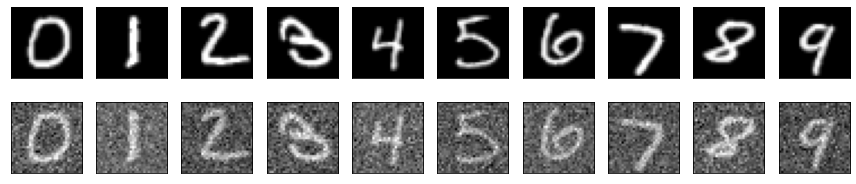

In [3]:
    # define parameters
    data_loc = os.path.abspath(".") #change the datalocation to something that works for you
    batch_size = 64
    
    # get dataloader
    train_loader,val_loader, test_loader = create_dataloaders(data_loc, batch_size)
    
    # get some examples
    examples = enumerate(test_loader)
    _, (x_clean_example, x_noisy_example, labels_example) = next(examples)
    # use these example images througout the assignment as the first 10 correspond to the digits 0-9
    
    # show the examples in a plot
    plt.figure(figsize=(12,3))
    for i in range(10):
        plt.subplot(2,10,i+1)
        plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(2,10,i+11)
        plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    
    plt.tight_layout()
    plt.savefig(r"figure\data_examples.png",dpi=300,bbox_inches='tight')
    plt.show()

check data size

In [4]:
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Interval for printing loss during training
print_every = 100

print(f'Using device:{device}')

Using device:cpu


## b) Build up a fully connected network with linear layers

In [5]:
class ThreeLayerFC_o_act(nn.Module):
    def __init__(self,in_neuron,hidden1_neuron,hidden2_neuron,out_neuron):
        super().__init__()
        self.fc1 = nn.Linear(in_neuron,hidden1_neuron)
        self.fc2 = nn.Linear(hidden1_neuron,hidden2_neuron)
        self.fc3 = nn.Linear(hidden2_neuron,out_neuron)
    def forward(self,x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

def test_ThreeLayerFC():
    x = torch.zeros((64,32,32)).view((64,32*32))
    model = ThreeLayerFC_o_act(in_neuron=32*32,hidden1_neuron=64*64,hidden2_neuron=128*128,out_neuron=32*32)
    result = model(x)
    print(result.shape)

test_ThreeLayerFC()

torch.Size([64, 1024])


In [15]:
# trainer, loss calculation and plot

def flatten(x):
    return x.view(len(x),-1)

def loss_epoch(loss_ls,model,loader) -> list:
    model.eval() # model in evaluation mode
    with torch.no_grad():
        loss_epoch=0
        for t,(x_clean,x_noisy,_) in enumerate(loader):
            x_noisy = x_noisy.to(device=device, dtype=torch.float32)
            x_clean = x_clean.to(device=device, dtype=torch.float32)
            out_x = model(flatten(x_noisy))
            loss=F.mse_loss(out_x,flatten(x_clean))
            loss_epoch += loss
        loss_ls.append(loss_epoch/t)

def loss_batch(loss_ls,model,loader) -> list:
    model.eval() # model in evaluation mode
    with torch.no_grad():
        for _,(x_clean,x_noisy,_) in enumerate(loader):
            x_noisy = x_noisy.to(device=device, dtype=torch.float32)
            x_clean = x_clean.to(device=device, dtype=torch.float32)
            out_x = model(flatten(x_noisy))
            loss=F.mse_loss(out_x,flatten(x_clean))
            loss_ls.append(loss)   

def trainer(model,optimizer, epochs=1):
    loss_train = []
    loss_val = []
    model = model.to(device=device)
    for e in range(epochs):
        for _,(x_clean,x_noisy,_) in enumerate(train_loader):
            x_noisy = x_noisy.to(device=device, dtype=torch.float32)
            x_clean = x_clean.to(device=device, dtype=torch.float32)
            model.train() # training mode
            out_x = model(flatten(x_noisy))
            loss = F.mse_loss(out_x,flatten(x_clean))
            optimizer.zero_grad() #reset gradients
            loss.backward()
            optimizer.step()
        loss_epoch(loss_train,model,train_loader)
        loss_epoch(loss_val,model,val_loader)
        print(f'epoch {e+1}:train loss={loss_train[e]},val loss={loss_val[e]}')
    return loss_train,loss_val

def loss_plot(loss_train,loss_val,epoch,figname:str):
    x = range(1,epoch+1)
    plt.plot(x,loss_train,'r-',label="training loss")
    plt.plot(x,loss_val,'k:',label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss(MSE)")
    plt.title("Train/Val Loss")
    plt.legend()
    plt.savefig(f"figure/{figname}.png")
    plt.show()

def prediction(model,x): #test
    model = model.to(device=device)
    model.eval()
    with torch.no_grad():
        x = x.to(device=device,dtype=torch.float32)
        out_x = torch.Tensor.cpu(model(flatten(x)))
    return out_x


In [ ]:
in_neuron=32*32
hidden1_neuron=64*64
hidden2_neuron=64*64
out_neuron=32*32

lr = 1e-3

model_o_act = ThreeLayerFC_o_act(in_neuron,hidden1_neuron,hidden2_neuron,out_neuron)
optimizer = optim.SGD(model_o_act.parameters(),lr) #default momentum=0
epoch=20

train_loss,val_loss = trainer(model_o_act,optimizer,epoch)
loss_plot(train_loss,val_loss,epoch,"loss_o_act")
PATH = os.path.join(os.path.abspath("."), "model")
torch.save(model_o_act,PATH)

In [ ]:
model_o_act_untrained = ThreeLayerFC_o_act(in_neuron,hidden1_neuron,hidden2_neuron,out_neuron)

# get some examples
examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)

# prediction
x_untrained_example = prediction(model_o_act_untrained,x_noisy_example).reshape(64,1,32,32)
x_trained_example = prediction(model_o_act,x_noisy_example).reshape(64,1,32,32)

# comparison of trained/untrained examples with clean and noisy figures
plt.figure(figsize=(40,10))
for i in range(10):
    plt.subplot(4,10,i+1)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(4,10,i+11)
    plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(4,10,i+21)
    plt.imshow(x_untrained_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(4,10,i+31)
    plt.imshow(x_trained_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
        
plt.tight_layout()
plt.savefig(r"figure/data_examples_o_act.png",dpi=300,bbox_inches='tight')
plt.show()

## Linear layers with activation(ReLu)

In [8]:
def ReLu(x):
    y = torch.zeros_like(x)
    return torch.where(x>0,x,y)

#test ReLu
test_relu= torch.randn(3,2)
print(test_relu)
print(ReLu(test_relu))

tensor([[-0.5618,  0.5106],
        [-2.3186,  1.0196],
        [-1.1985,  0.9491]])
tensor([[0.0000, 0.5106],
        [0.0000, 1.0196],
        [0.0000, 0.9491]])


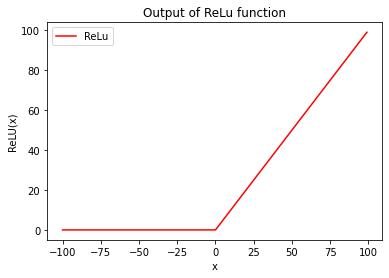

In [9]:
# plot the relu
plot_relu_x = torch.arange(-100,100,1)
plot_relu_y = ReLu(plot_relu_x)
plt.plot(plot_relu_x,plot_relu_y,'r-',label="ReLu")
plt.xlabel("x")
plt.ylabel("ReLU(x)")
plt.title("Output of ReLu function")
plt.legend()
plt.savefig(r'figure/ReLu.png')
plt.show()

In [10]:
# model with ReLU activation
class ThreeLayerFC_act(nn.Module):
    def __init__(self,in_neuron,hidden1_neuron,hidden2_neuron,out_neuron):
        super().__init__()
        self.fc1 = nn.Linear(in_neuron,hidden1_neuron)
        self.fc2 = nn.Linear(hidden1_neuron,hidden2_neuron)
        self.fc3 = nn.Linear(hidden2_neuron,out_neuron)
    def forward(self,x):
        x = ReLu(self.fc1(x))
        x = ReLu(self.fc2(x))
        x = self.fc3(x)
        return x

epoch 1:train loss=0.05511774495244026,val loss=0.05580182746052742
epoch 2:train loss=0.04309292137622833,val loss=0.044214654713869095
epoch 3:train loss=0.037048596888780594,val loss=0.03838087245821953
epoch 4:train loss=0.035132259130477905,val loss=0.03673047199845314
epoch 5:train loss=0.032523710280656815,val loss=0.034185513854026794
epoch 6:train loss=0.03211824968457222,val loss=0.03387013077735901
epoch 7:train loss=0.030287539586424828,val loss=0.03212513402104378
epoch 8:train loss=0.03006630763411522,val loss=0.03200763091444969
epoch 9:train loss=0.028381431475281715,val loss=0.030314449220895767
epoch 10:train loss=0.02827070653438568,val loss=0.030305055901408195
epoch 11:train loss=0.02735314518213272,val loss=0.029363559558987617
epoch 12:train loss=0.027439899742603302,val loss=0.029502548277378082
epoch 13:train loss=0.027123430743813515,val loss=0.02916419878602028
epoch 14:train loss=0.027793560177087784,val loss=0.02991936169564724
epoch 15:train loss=0.0270014

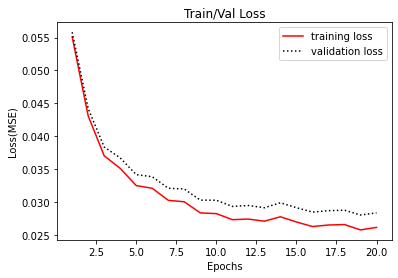

In [12]:
in_neuron=32*32
hidden1_neuron=64*64
hidden2_neuron=64*64
out_neuron=32*32

lr = 1e-3

model_act = ThreeLayerFC_act(in_neuron,hidden1_neuron,hidden2_neuron,out_neuron)
optimizer_act = optim.Adam(model_act.parameters(),lr)
epoch=20

train_loss_act,val_loss_act = trainer(model_act,optimizer_act,epoch)
loss_plot(train_loss_act,val_loss_act,epoch,"loss_act")
PATH = os.path.join(os.path.abspath("."), "model_act")
torch.save(model_act,PATH)

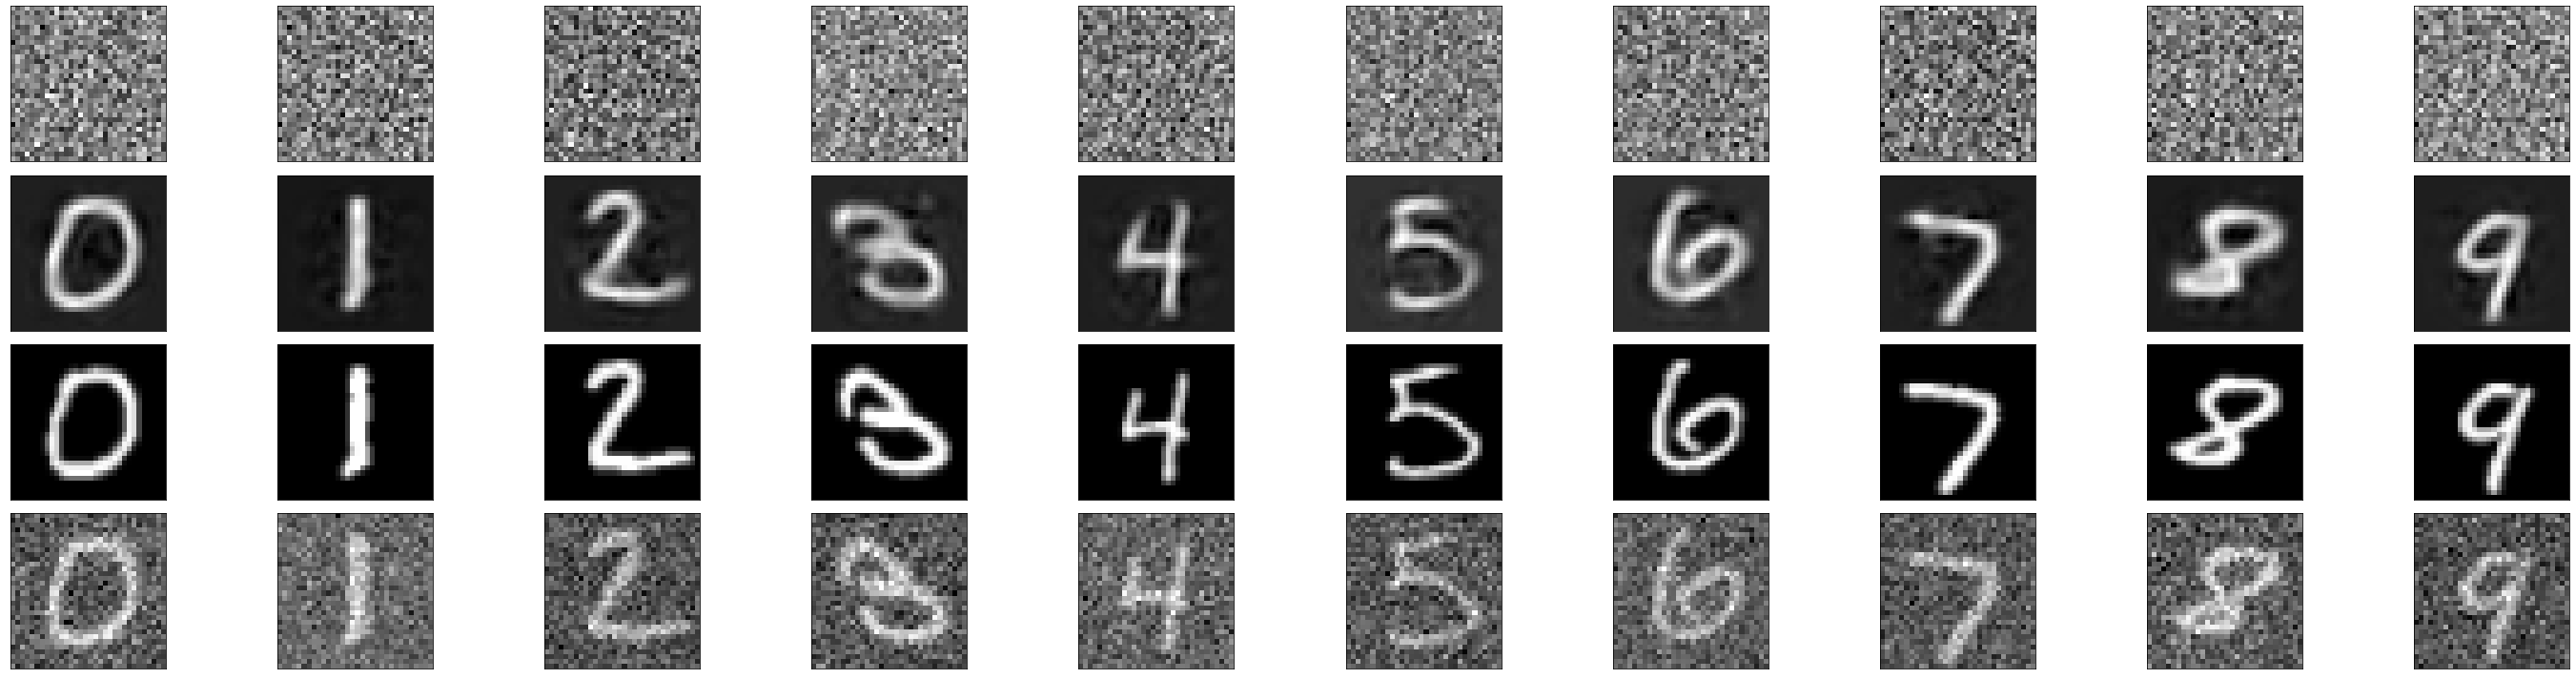

In [18]:
model_act_untrained = ThreeLayerFC_act(in_neuron,hidden1_neuron,hidden2_neuron,out_neuron)

# get some examples
examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)

# prediction
x_untrained_example = prediction(model_act_untrained,x_noisy_example).reshape(64,1,32,32)
x_trained_example = prediction(model_act,x_noisy_example).reshape(64,1,32,32)

# comparison of trained/untrained examples with clean and noisy figures
plt.figure(figsize=(40,10))
for i in range(10):
    plt.subplot(4,10,i+21)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(4,10,i+31)
    plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(4,10,i+1)
    plt.imshow(x_untrained_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(4,10,i+11)
    plt.imshow(x_trained_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
        
plt.tight_layout()
plt.savefig(r"figure/data_examples_act.png",dpi=300,bbox_inches='tight')
plt.show()

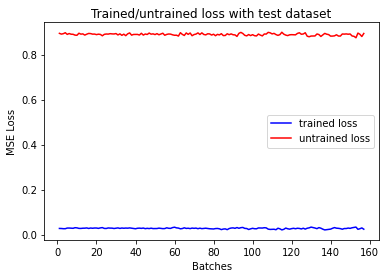

In [16]:
# get loss on the test dataset
loss_trained = []
loss_untrained = []
loss_batch(loss_trained, model_act, test_loader)
loss_batch(loss_untrained, model_act_untrained, test_loader)

# plot graph
x = range(1, len(loss_trained)+1)
plt.plot(x, loss_trained, 'b-', label="trained loss")
plt.plot(x, loss_untrained, 'r-', label="untrained loss")
plt.xlabel("Batches")
plt.ylabel("MSE Loss")
plt.title("Trained/untrained loss with test dataset")
plt.legend()
plt.savefig(r"figure/trained_and_untrained_loss_act.png")
plt.show()